[Reference](https://medium.com/@andresberejnoi/advanced-plots-with-pandas-and-matplotlib-andres-berejnoi-1c94391fd17b)

In [2]:
!pip install wbgapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import os

#from collections import Simplenamespace

import wbgapi as wb   #package for retrieving data from the Wold Bank 

In [5]:
def clean_up_df(df, country_codes, column_name_mapper):
    """This function is not general. Clean up column names for df
    Rename columns based on color mapper. 
    Break up the original df into several dfs for each country.
    
    Returns
    -------
    Dictionary of pandas.DataFrame"""
    dfs_dict:dict = {}
    for country in country_codes:
        partial_df        = df.loc[country]
        partial_df.index  = pd.to_datetime(partial_df.index, format='YR%Y')  #turn the index into actual datetime objects
        partial_df        = partial_df.rename(column_name_mapper, axis=1)
        dfs_dict[country] = partial_df
    
    return dfs_dict

# Define the Data Series That We Want



In [6]:
#here are some interesting codes to look at
_world_bank_codes = [
    'NY.GDP.MKTP.CD',     #GDP total
    'NY.GDP.MKTP.KD.ZG',  #GDP growth, annual
    'SP.POP.TOTL',      #total population
    'EN.ATM.CO2E.KT',   #CO2 emisions
    'NY.GDP.PCAP.CD',   #GDP per capita
    'NY.GDP.MKTP.PP.CD'  #GDP, PPP 
]
info_series = wb.series.info(_world_bank_codes)  #print code meanings
info_series

id,value
EN.ATM.CO2E.KT,CO2 emissions (kt)
NY.GDP.MKTP.CD,GDP (current US$)
NY.GDP.MKTP.KD.ZG,GDP growth (annual %)
NY.GDP.PCAP.CD,GDP per capita (current US$)
NY.GDP.MKTP.PP.CD,"GDP, PPP (current international $)"
SP.POP.TOTL,"Population, total"
,6 elements


In [7]:
series_mapper = {
    'gdp'           : 'NY.GDP.MKTP.CD',
    'gdp_per_capita': 'NY.GDP.PCAP.CD',
    'gdp_growth'    : 'NY.GDP.MKTP.KD.ZG',
    'gdp_ppp'       : 'NY.GDP.MKTP.PP.CD',
    'population'    : 'SP.POP.TOTL',
    'co2'           : 'EN.ATM.CO2E.KT',
}

# Create Coder For Country Names


In [8]:
# get World bank official code names for current top 10 economies in the world
_top_countries = [
    'United States', 
    'China', 
    'Japan',
    'Germany',
    'United Kingdom', 
    'India',
    'France',
    'Italy',
    'Canada',
    'South Korea',
]


country_coder = wb.economy.coder(_top_countries)
country_coder

ORIGINAL NAME,WBG NAME,ISO_CODE
United States,United States,USA
China,China,CHN
Japan,Japan,JPN
Germany,Germany,DEU
United Kingdom,United Kingdom,GBR
India,India,IND
France,France,FRA
Italy,Italy,ITA
Canada,Canada,CAN
South Korea,"Korea, Rep.",KOR


In [9]:
#use it like a dictionary
country_coder['Italy']

'ITA'

# Fetch the Data


In [10]:
_wanted_series = [
    series_mapper['gdp'],
    series_mapper['gdp_ppp'],
    series_mapper['gdp_growth'],
    series_mapper['population'],
]

full_df = wb.data.DataFrame(
            series     = _wanted_series, 
            economy    = country_coder.values(),
            time       = 'all', 
            skipBlanks = True, 
            columns    = 'series',
            #index      = 'time',
)

In [11]:
#The returned df has cryptic words and labels. I will modify it.
full_df

NY.GDP.MKTP.CD  NY.GDP.MKTP.KD.ZG  NY.GDP.MKTP.PP.CD  \
economy time                                                           
CAN     YR1960    4.046172e+10                NaN                NaN   
        YR1961    4.093495e+10           3.163292                NaN   
        YR1962    4.222745e+10           7.425385                NaN   
        YR1963    4.502999e+10           5.349546                NaN   
        YR1964    4.937752e+10           6.642894                NaN   
...                        ...                ...                ...   
USA     YR2016    1.874508e+13           1.711427       1.874508e+13   
        YR2017    1.954298e+13           2.332679       1.954298e+13   
        YR2018    2.061186e+13           2.996464       2.061186e+13   
        YR2019    2.143322e+13           2.161177       2.143322e+13   
        YR2020    2.095303e+13          -3.404592       2.095303e+13   

                SP.POP.TOTL  
economy time                 
CAN     YR1960   17909009.0  
        YR1961   18271000.0  
        YR1962   18614000.0  
        YR1963   18964000.0  
        YR1964   19325000.0  
...                     ...  
USA     YR2016  323071755.0  
        YR2017  325122128.0  
        YR2018  326838199.0  
        YR2019  328329953.0  
        YR2020  331501080.0  

[610 rows x 4 columns]

# Clean Up the DataFrame



In [12]:
inverse_series_mapper = {val:key for key,val in series_mapper.items()}

dfs_dict:dict = clean_up_df(full_df, country_coder.values(), inverse_series_mapper)

In [13]:
dfs_dict['USA']  #test a single dataframe

,gdp,gdp_growth,gdp_ppp,population
time,,,,
1960-01-01,5.433000e+11,NaN,NaN,180671000.0
1961-01-01,5.633000e+11,2.300000,NaN,183691000.0
1962-01-01,6.051000e+11,6.100000,NaN,186538000.0
1963-01-01,6.386000e+11,4.400000,NaN,189242000.0
1964-01-01,6.858000e+11,5.800000,NaN,191889000.0
...,...,...,...,...
2016-01-01,1.874508e+13,1.711427,1.874508e+13,323071755.0
2017-01-01,1.954298e+13,2.332679,1.954298e+13,325122128.0
2018-01-01,2.061186e+13,2.996464,2.061186e+13,326838199.0


# Plotting Section
## Set Font Size

In [14]:
def set_font_size(size=16):
    plt.rcParams.update({'font.size': f'{size}'}) # must set at the top. It controls text size in charts and plots

def set_dpi(dpi=120):
    plt.rcParams["figure.dpi"] = dpi
    
fig = plt.figure()

_set_font = True
_font_size = 12
if _set_font:
    set_font_size(_font_size)
    
_set_dpi = True
_dpi     = 120
if _set_dpi:
    set_dpi(_dpi)

<Figure size 432x288 with 0 Axes>

In [15]:
country = 'USA'
df = dfs_dict[country]

## Simple Pandas Subplot

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f19fe456c90>,
      dtype=object)

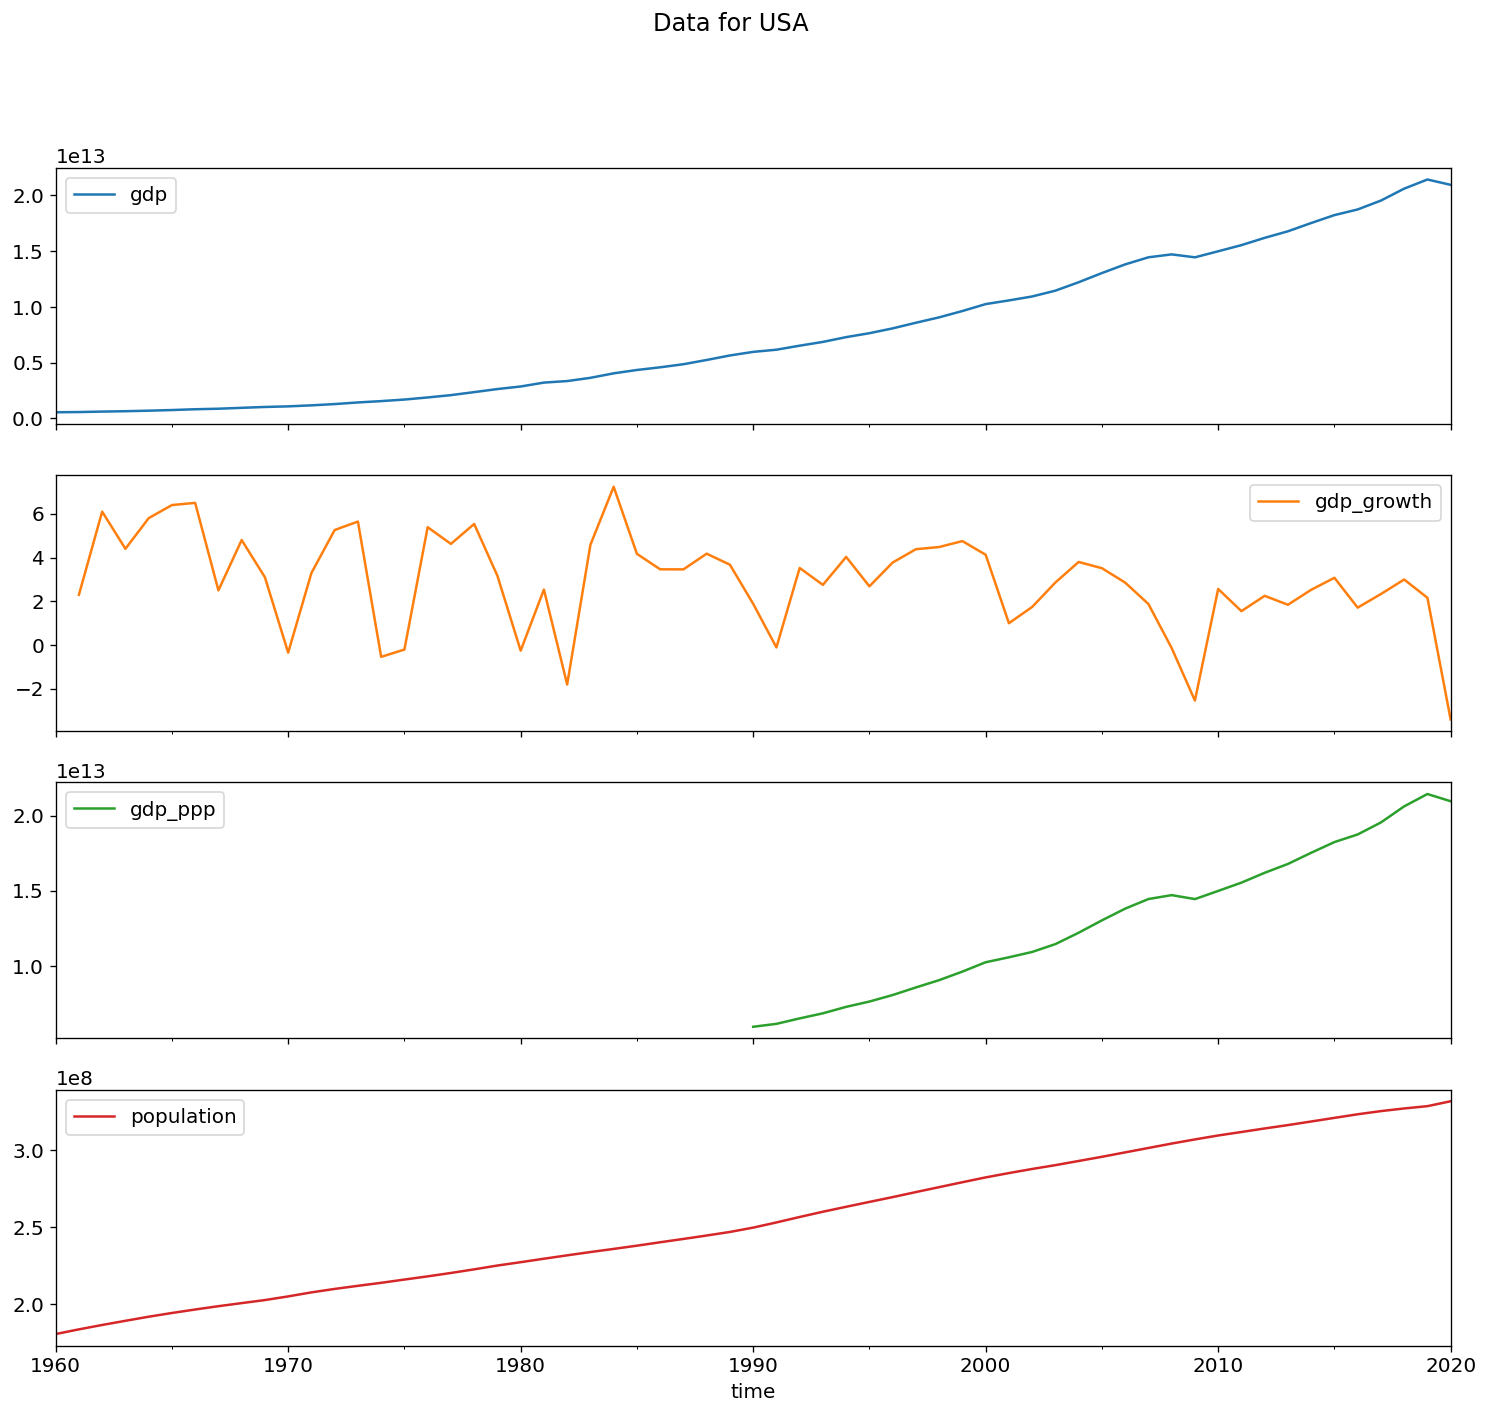

In [16]:
df.plot(
    subplots=True,
    figsize=(15,13),
    title   = f'Data for {country}'
)

## Advanced Plot - Modify Axes objects


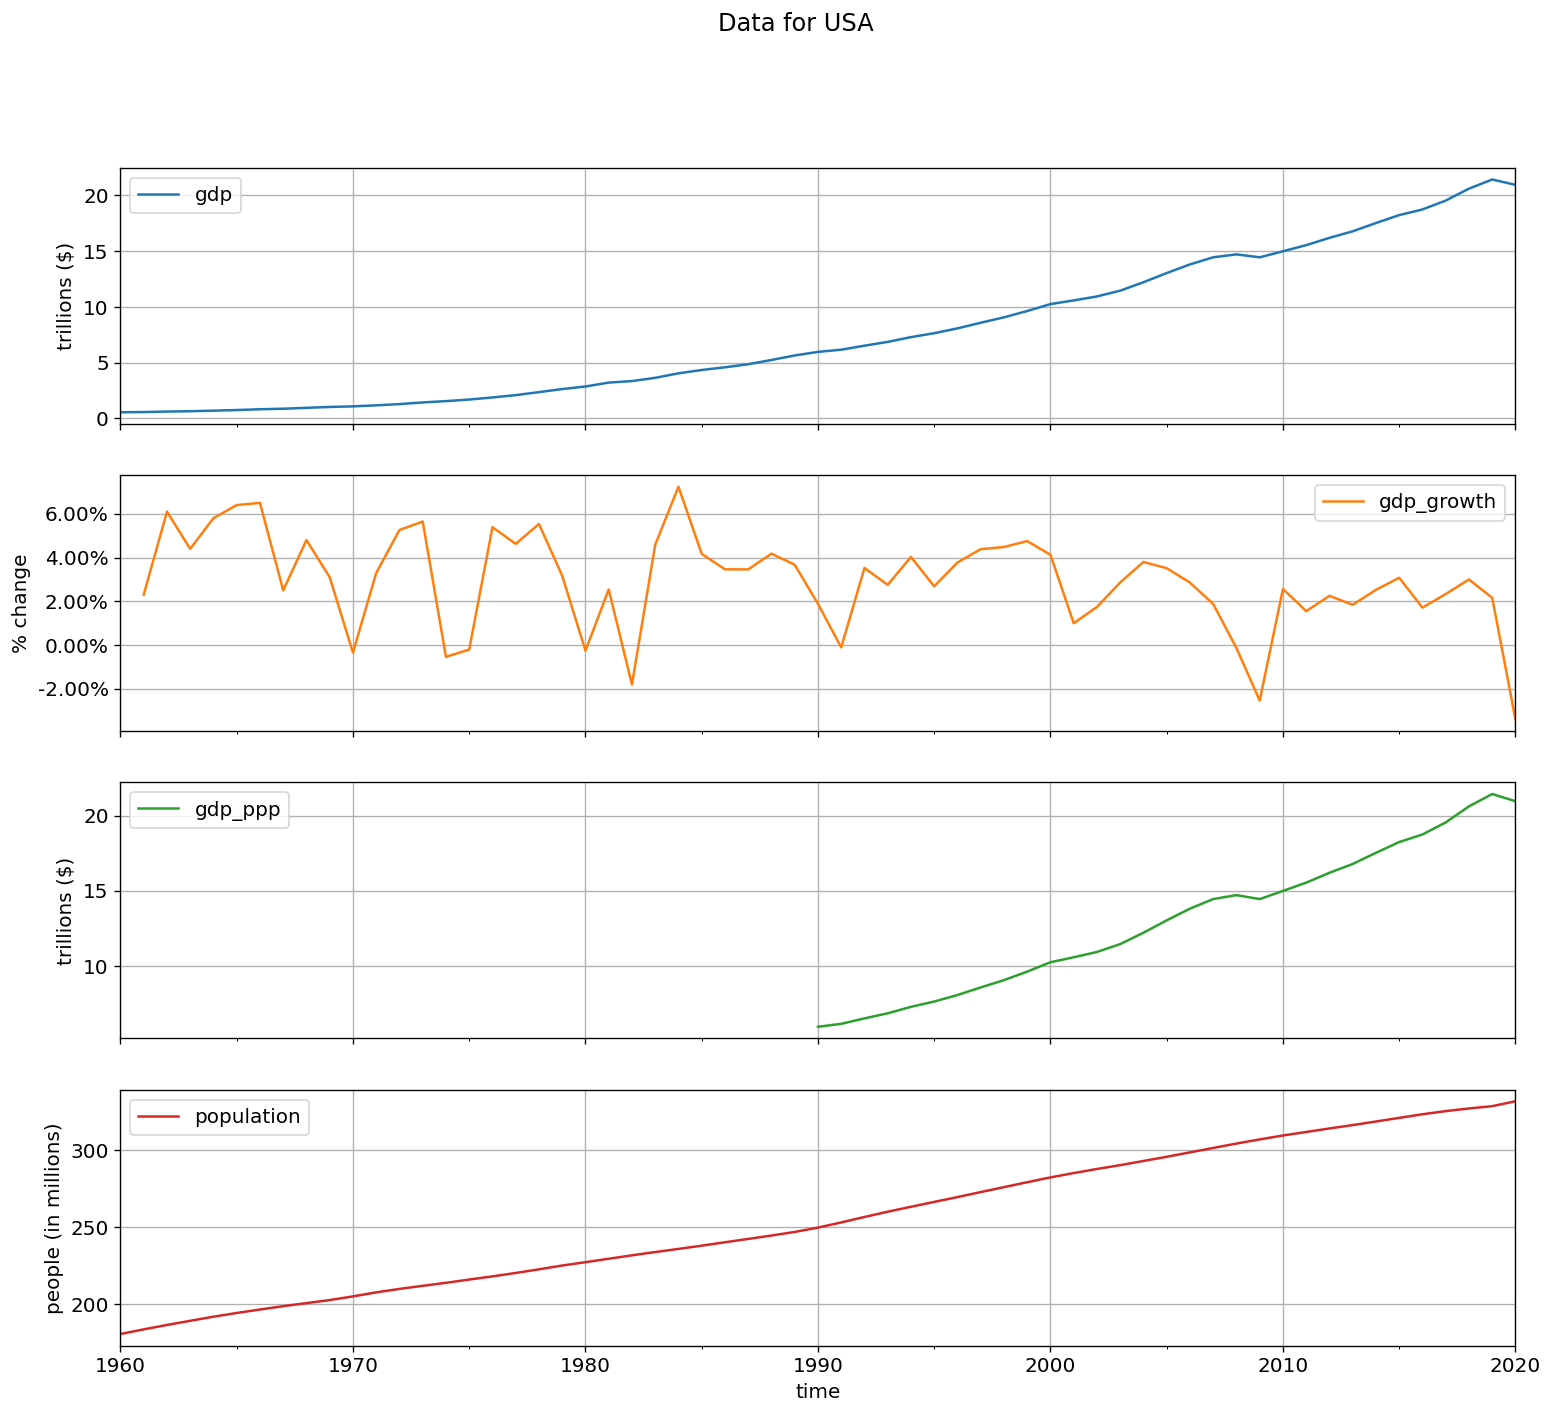

In [17]:
axes_list = df.plot(subplots=True,
                figsize =(15,13),
                title   = f'Data for {country}',
                grid    = True,
)

#-- Define helper labels and variables
one_trillion = 1_000_000_000_000
one_million  = 1_000_000

ylabels = ['trillions ($)', '% change', 'trillions ($)', 'people (in millions)']

for i, ax in enumerate(axes_list):
    ax.set_ylabel(ylabels[i])

#-- format y tickers manually (it could be done in loop, but I kept getting some problems)
axes_list[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos: f"{x/one_trillion:,.0f}"))
axes_list[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos: f"{x:.2f}%"))
axes_list[2].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos: f"{x/one_trillion:,.0f}"))
axes_list[3].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos: f"{x/one_million:,.0f}"))

## Comparison Plots

In [18]:
usa_df = dfs_dict['USA']
china_df = dfs_dict['CHN']

In [19]:
pd.merge(usa_df,china_df,on='gdp_ppp')

,gdp_x,gdp_growth_x,gdp_ppp,population_x,gdp_y,gdp_growth_y,population_y
0,5.433000e+11,NaN,NaN,180671000.0,5.971647e+10,NaN,6.670700e+08
1,5.433000e+11,NaN,NaN,180671000.0,5.005687e+10,-27.270000,6.603300e+08
2,5.433000e+11,NaN,NaN,180671000.0,4.720936e+10,-5.580000,6.657700e+08
3,5.433000e+11,NaN,NaN,180671000.0,5.070680e+10,10.300000,6.823350e+08
4,5.433000e+11,NaN,NaN,180671000.0,5.970834e+10,18.180000,6.983550e+08
...,...,...,...,...,...,...,...
895,5.641580e+12,3.672648,NaN,246819000.0,3.094880e+11,13.430678,1.051040e+09
896,5.641580e+12,3.672648,NaN,246819000.0,3.007581e+11,8.949962,1.066790e+09
897,5.641580e+12,3.672648,NaN,246819000.0,2.729730e+11,11.657428,1.084035e+09
898,5.641580e+12,3.672648,NaN,246819000.0,3.123536e+11,11.222595,1.101630e+09


In [20]:
usa_df

,gdp,gdp_growth,gdp_ppp,population
time,,,,
1960-01-01,5.433000e+11,NaN,NaN,180671000.0
1961-01-01,5.633000e+11,2.300000,NaN,183691000.0
1962-01-01,6.051000e+11,6.100000,NaN,186538000.0
1963-01-01,6.386000e+11,4.400000,NaN,189242000.0
1964-01-01,6.858000e+11,5.800000,NaN,191889000.0
...,...,...,...,...
2016-01-01,1.874508e+13,1.711427,1.874508e+13,323071755.0
2017-01-01,1.954298e+13,2.332679,1.954298e+13,325122128.0
2018-01-01,2.061186e+13,2.996464,2.061186e+13,326838199.0


In [21]:
china_df

,gdp,gdp_growth,gdp_ppp,population
time,,,,
1960-01-01,5.971647e+10,NaN,NaN,6.670700e+08
1961-01-01,5.005687e+10,-27.270000,NaN,6.603300e+08
1962-01-01,4.720936e+10,-5.580000,NaN,6.657700e+08
1963-01-01,5.070680e+10,10.300000,NaN,6.823350e+08
1964-01-01,5.970834e+10,18.180000,NaN,6.983550e+08
...,...,...,...,...
2016-01-01,1.123328e+13,6.848762,1.871210e+13,1.387790e+09
2017-01-01,1.231041e+13,6.947201,1.988703e+13,1.396215e+09
2018-01-01,1.389482e+13,6.749774,2.173908e+13,1.402760e+09


## Example Bar Plot

[Text(0, 0, '1960'),
 Text(0, 0, '1961'),
 Text(0, 0, '1962'),
 Text(0, 0, '1963'),
 Text(0, 0, '1964'),
 Text(0, 0, '1965'),
 Text(0, 0, '1966'),
 Text(0, 0, '1967'),
 Text(0, 0, '1968'),
 Text(0, 0, '1969'),
 Text(0, 0, '1970'),
 Text(0, 0, '1971'),
 Text(0, 0, '1972'),
 Text(0, 0, '1973'),
 Text(0, 0, '1974'),
 Text(0, 0, '1975'),
 Text(0, 0, '1976'),
 Text(0, 0, '1977'),
 Text(0, 0, '1978'),
 Text(0, 0, '1979'),
 Text(0, 0, '1980'),
 Text(0, 0, '1981'),
 Text(0, 0, '1982'),
 Text(0, 0, '1983'),
 Text(0, 0, '1984'),
 Text(0, 0, '1985'),
 Text(0, 0, '1986'),
 Text(0, 0, '1987'),
 Text(0, 0, '1988'),
 Text(0, 0, '1989'),
 Text(0, 0, '1990'),
 Text(0, 0, '1991'),
 Text(0, 0, '1992'),
 Text(0, 0, '1993'),
 Text(0, 0, '1994'),
 Text(0, 0, '1995'),
 Text(0, 0, '1996'),
 Text(0, 0, '1997'),
 Text(0, 0, '1998'),
 Text(0, 0, '1999'),
 Text(0, 0, '2000'),
 Text(0, 0, '2001'),
 Text(0, 0, '2002'),
 Text(0, 0, '2003'),
 Text(0, 0, '2004'),
 Text(0, 0, '2005'),
 Text(0, 0, '2006'),
 Text(0, 0, '

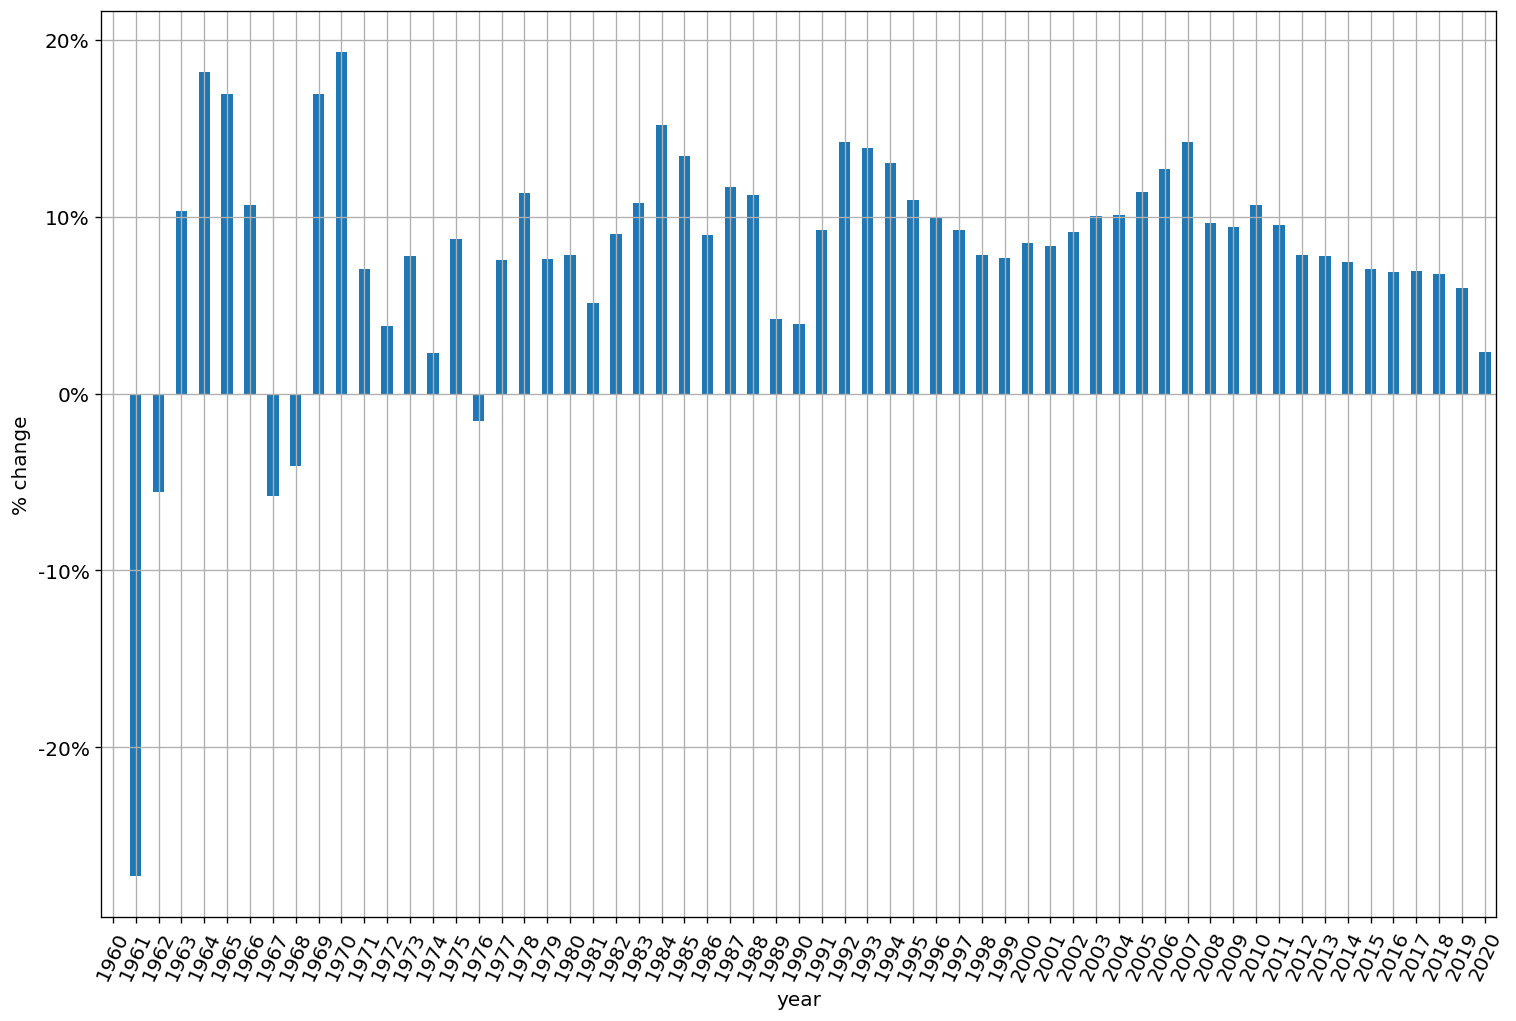

In [27]:
ax = china_df['gdp_growth'].plot(
        kind    = 'bar',
        figsize = (15,10),
        grid    = True,
        title   = '',
        #by='gdp_growth',
        #alpha=0.5,  #adjust transparency of bars and lines
)

ax.set_ylabel("% change")
ax.set_xlabel("year")
#ax.set_xlabel('time')

#-- format look of yticks
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos: f"{x:.0f}%"))


#-- format the look of the xticks
#ax.xaxis.set_major_formatter(DateFormatter('%Y'))

ax.set_xticklabels([i for i in range(1960,2021)], rotation=65, horizontalalignment="center")

In [25]:
usa_df

,gdp,gdp_growth,gdp_ppp,population
time,,,,
1960-01-01,5.433000e+11,NaN,NaN,180671000.0
1961-01-01,5.633000e+11,2.300000,NaN,183691000.0
1962-01-01,6.051000e+11,6.100000,NaN,186538000.0
1963-01-01,6.386000e+11,4.400000,NaN,189242000.0
1964-01-01,6.858000e+11,5.800000,NaN,191889000.0
...,...,...,...,...
2016-01-01,1.874508e+13,1.711427,1.874508e+13,323071755.0
2017-01-01,1.954298e+13,2.332679,1.954298e+13,325122128.0
2018-01-01,2.061186e+13,2.996464,2.061186e+13,326838199.0


## Another Way to Have Multiple Layouts

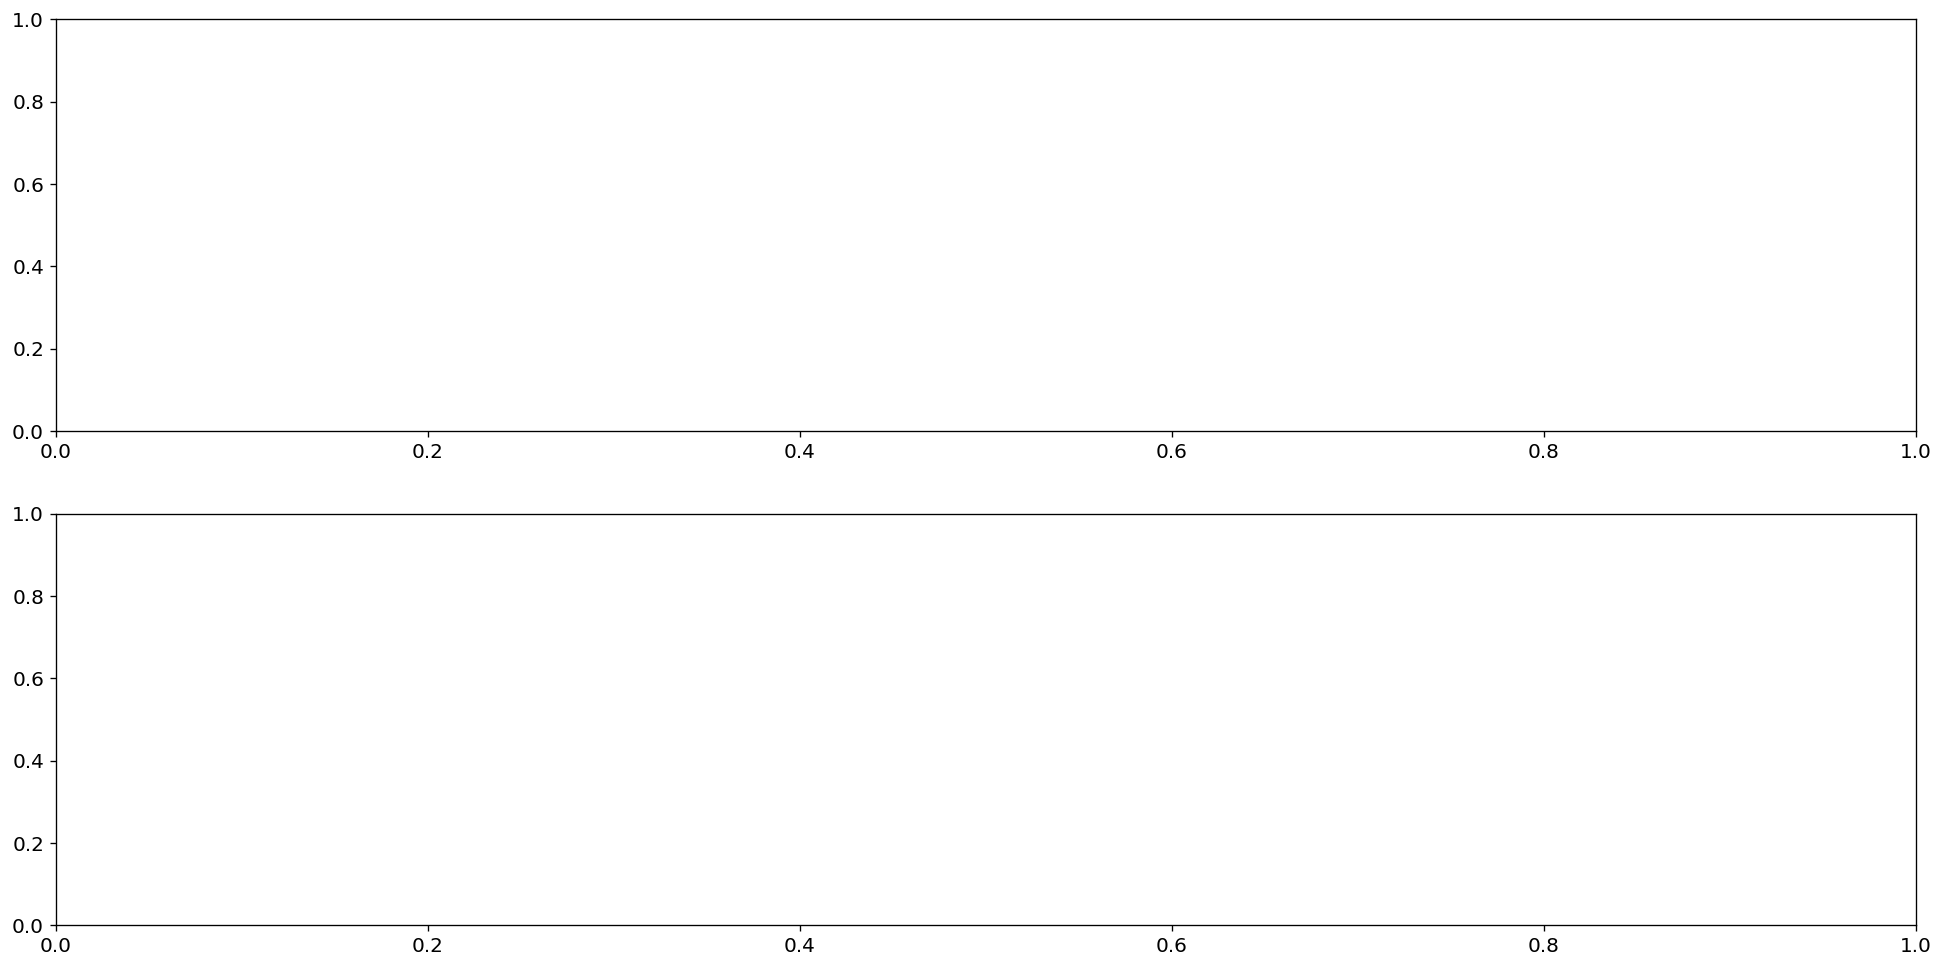

In [28]:
fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

## Plot of Purchasing Power Parity GDP and Population (USA vs China)

In [33]:
# fig = plt.figure(
#         constrained_layout=True, 
#         figsize=(20,10)
# )

# fig.set_dpi(120)
# axs = plt.subplot_mosaic([['top'],['bottom']],
#                           gridspec_kw={'height_ratios':[2, 1]},
#                          sharex=True)

# #-- plot the data
# axs['top'].plot(usa_df['gdp_ppp'], label='USA')
# axs['top'].plot(china_df['gdp_ppp'], label='China')

# axs['bottom'].plot(usa_df['population'], label='USA')
# axs['bottom'].plot(china_df['population'], label='China')

# #-- set axis labels
# axs['top'].set_ylabel('PPP GDP (in trillions $)')
# axs['bottom'].set_ylabel("population (in millions)")

# #-- set grid lines
# axs['top'].grid()
# axs['bottom'].grid()

# #-- set subplot titles
# axs['top'].set_title('Purchasing Power Parity GDP (USA vs China)')
# axs['bottom'].set_title('Population')

# #-- set subplot legends
# axs['top'].legend()
# axs['bottom'].legend()


# #-- format tick labels
# axs['top'].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos: f"{x/one_trillion:,.0f}"))
# axs['bottom'].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos: f"{x/one_million:,.0f}"))